In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
train = pd.read_csv('../tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../tmdb-box-office-prediction/test.csv')
sample_submission = pd.read_csv('../tmdb-box-office-prediction/sample_submission.csv')

### Initial data exploration

In [3]:
# Not a lot of observations left in the train set. Hopefully it'll be 
# enough to train a decent model.

train.shape, test.shape, sample_submission.shape

((3000, 23), (4398, 22), (4398, 2))

In [4]:
# Many 0 values for budget
# 812 movies have 0 for budget in train, 1211 in test
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [5]:
train.describe(exclude='number')

,belongs_to_collection,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,Keywords,cast,crew
count,604,2993,946,3000,3000,3000,2992,2999,2844,2945,3000,2980,3000,2403,3000,2724,2987,2984
unique,422,872,941,3000,36,2975,2992,2999,2383,321,2398,401,2,2400,2969,2648,2975,2984
top,"[{'id': 645, 'name': 'James Bond Collection', ...","[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0379217,en,Bad Boys,An ancient Indian warrior who has reached the ...,/iO1J7a0kzgqdfP9g4F5pyaczp9R.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/15,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Hercules,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '547b481f9251412d7f00007a', 'de..."
freq,16,266,4,1,2575,2,1,1,51,1752,5,1817,2996,3,2,27,13,1


In [6]:
train.head().T

,0,1,2,3,4
id,1,2,3,4,5
belongs_to_collection,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...","[{'id': 107674, 'name': 'The Princess Diaries ...",NaN,NaN,NaN
budget,14000000,40000000,3300000,1200000,0
genres,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 18, 'name': 'Drama'}]","[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...","[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam..."
homepage,NaN,NaN,http://sonyclassics.com/whiplash/,http://kahaanithefilm.com/,NaN
imdb_id,tt2637294,tt0368933,tt2582802,tt1821480,tt1380152
original_language,en,en,en,hi,ko
original_title,Hot Tub Time Machine 2,The Princess Diaries 2: Royal Engagement,Whiplash,Kahaani,마린보이
overview,"When Lou, who has become the ""father of the In...",Mia Thermopolis is now a college graduate and ...,"Under the direction of a ruthless instructor, ...",Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,Marine Boy is the story of a former national s...
popularity,6.57539,8.24889,64.3,3.17494,1.14807


### Wrangle data

In [7]:
# wrangle function
def wrangle(X):
    
    # Convert columns with string representations of lists to lists (of dictionaries)
    # This is a common issue when saving and loading pandas DataFrames as .csv files.
    string_list = ['belongs_to_collection', 'genres', 'production_companies',
                   'production_countries', 'spoken_languages', 'Keywords', 
                   'cast', 'crew']

    for col in string_list:
        X.loc[:,col] = X.loc[:,col].apply(lambda x: literal_eval(x) 
                                          if type(x)==str else np.nan)
        
    # Add feature: 1 if movie belongs to a collection, 0 otherwise
    X['collection'] = X['belongs_to_collection'].notnull().astype(int)
    
    # Add feature: 1 if movie released, 0 otherwise
    X['released'] = X['status'].apply(lambda x: 1 if x=='Released' else 0)
    
    # Add feature: 1 if movie has a homepage, 0 otherwise
    # Might covary with budget
    X['has_homepage'] = X['homepage'].notnull().astype(int)
    
    # Get features for collection_id and collection_name
    X['collection_id'] = X['belongs_to_collection'].apply(lambda x: x[0]['id']
                                                          if type(x)==list else 0)
    X['collection_name'] = X['belongs_to_collection'].apply(lambda x: x[0]['name'] 
                                                            if type(x)==list else np.nan)
    
    # Create a feature that is release_date in datetime format
    # Extract year, month, day, dayofweek, and quarter. Drop datetime feature
    X['release_date_dt'] = pd.to_datetime(X['release_date'], infer_datetime_format=True)
    X['release_year'] = X['release_date_dt'].dt.year.apply(lambda x: 
                                                           x if x < 2020 
                                                           else x - 100)
    X['release_month'] = X['release_date_dt'].dt.month
    X['release_day'] = X['release_date_dt'].dt.day
    X['release_dayofweek'] = X['release_date_dt'].dt.dayofweek
    X['release_quarter'] = X['release_date_dt'].dt.quarter
    X = X.drop('release_date_dt', axis=1)
    
    # Get genre list for each movie
    X['list_of_genres'] = list(X['genres'].apply(lambda x: [i['name'] for i in x]
                                                 if type(x) == list
                                                 else []).values)
    
    # Create str feature with all genres of each movie
    X['all_genres'] = X['list_of_genres'].apply(lambda x: ", ".join(x))
    
    # One hot encode genre lists
    mlb = MultiLabelBinarizer()
    X = X.join(pd.DataFrame(mlb.fit_transform(X.pop('list_of_genres')),
                                              columns=mlb.classes_, index=X.index))

#     # Uncomment to create one-hot features for each language. Doesn't help model.  
#     top_languages = ['en', 'fr', 'ru', 'es', 'hi', 'ja', 'it', 'ko', 'cn', 'zh', 'de', 'ta']
    
#     for i in top_languages:
#         X['language_' + i] = X['original_language'].apply(lambda x: 1 if x==i else 0)
    
    X['original_english'] = X['original_language'].apply(lambda x: 1 if x=='en' else 0)
  
    # Gets string with name of first listed production company
    X['production_company'] = X['production_companies'].apply(lambda x: x[0]['name'] 
                                                            if type(x)==list else np.nan)
    return X


In [8]:
train_wrangled = wrangle(train)
test_wrangled = wrangle(test)

In [9]:
train_wrangled.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,original_english,production_company
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,1,Paramount Pictures
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,1,0,0,0,0,0,1,Walt Disney Pictures
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,1,Bold Films
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,1,0,0,0,NaN
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,1,0,0,0,NaN


In [10]:
# TV Movie has one occurence, only in train
train_wrangled.drop('TV Movie', axis=1, inplace=True)

In [11]:
train_wrangled.shape, test_wrangled.shape

((3000, 55), (4398, 54))

In [12]:
train_wrangled.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
collection                  0
released                    0
has_homepage                0
collection_id               0
collection_name          2396
release_year                0
release_month               0
release_day                 0
release_dayofweek           0
release_quarter             0
all_genres

## Modeling

### Split into X feature matrix and y target vector

In [15]:
features = ['budget', 'runtime', 'collection', 'released', 'all_genres', 'popularity',
            'has_homepage', 'collection_id', 'release_year', 'release_month', 
            'release_day', 'release_dayofweek', 'release_quarter', 
            'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
            'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 
            'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
            'Thriller', 'War', 'Western', 'original_english', 'production_company']
target = 'revenue'

In [16]:
X = train_wrangled[features]
y = train_wrangled[target]
X_test = test_wrangled[features]

In [17]:
# train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((2700, 34), (300, 34), (2700,), (300,), (4398, 34))

### Make pipeline and fit it

In [57]:
# Make pipeline
# commented out the encoder because I believe wrangle() is taking care of it now
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=5000, random_state=42, n_jobs=-1)
)

In [58]:
# Fit
pipeline.fit(X_train, y_train_log)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['all_genres', 'production_company'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value',
        mapping=[{'col': 'all_genres', 'mapping': Comedy, Drama                                                      1
Horror, Com...imators=5000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

### Validate

In [59]:
# evaluation functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [60]:
# Validate
y_pred = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred))

Validation Error 1.8566699010238532


### Generate predictions

In [61]:
# prediction function
def generate_submission(estimator, X_test_param, filename):
    y_pred_log = estimator.predict(X_test_param)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv('../tmdb-box-office-prediction/sample_submission.csv')
    submission['revenue'] = y_pred
    submission.to_csv(filename, index=False)

In [62]:
# make predictions
# first Kaggle submission RMSE: 3.24910
generate_submission(pipeline, X_test, 'tmdb_sub_20.csv')

### XG Boost

In [22]:
# X_test has 1 NaN for each dt feature, 4 NaN for runtime
# I should probably just run an imputer on all of these
# what's the deal with simpleimputer returning an array 
# and iterativeimputer being experimental and impossible to import?
X_test = X_test.fillna(X_test.median())
X_train = X_train.fillna(X_test.median())
X_val = X_val.fillna(X_val.median())

In [23]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [24]:
X_train_encoded.shape, X_val_encoded.shape, X_test_encoded.shape

((2700, 34), (300, 34), (4398, 34))

In [63]:
eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]

model = XGBRegressor(n_estimators=1000, n_jobs=-1, eta=0.001, max_depth=1)
model.fit(X_train_encoded, y_train_log, eval_set=eval_set, eval_metric='rmse',
         early_stopping_rounds=100)

[0]	validation_0-rmse:14.2246	validation_1-rmse:14.3149
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:12.8538	validation_1-rmse:12.9358
[2]	validation_0-rmse:11.6248	validation_1-rmse:11.7007
[3]	validation_0-rmse:10.5233	validation_1-rmse:10.5874
[4]	validation_0-rmse:9.53688	validation_1-rmse:9.58486
[5]	validation_0-rmse:8.65485	validation_1-rmse:8.69226
[6]	validation_0-rmse:7.86652	validation_1-rmse:7.89242
[7]	validation_0-rmse:7.16406	validation_1-rmse:7.17933
[8]	validation_0-rmse:6.53829	validation_1-rmse:6.53829
[9]	validation_0-rmse:5.98225	validation_1-rmse:5.96431
[10]	validation_0-rmse:5.48986	validation_1-rmse:5.45831
[11]	validation_0-rmse:5.05487	validation_1-rmse:5.0083
[12]	validation_0-rmse:4.67187	validation_1-rmse:4.60419
[13]	validation_0-rmse:4.33549	validation_1-rmse:4.24882
[14]	validation_0-rmse:4.04202	validation_1-rmse:3.94

[141]	validation_0-rmse:2.17173	validation_1-rmse:1.89382
[142]	validation_0-rmse:2.17124	validation_1-rmse:1.8944
[143]	validation_0-rmse:2.17075	validation_1-rmse:1.89418
[144]	validation_0-rmse:2.17026	validation_1-rmse:1.89377
[145]	validation_0-rmse:2.16978	validation_1-rmse:1.89441
[146]	validation_0-rmse:2.16932	validation_1-rmse:1.89467
[147]	validation_0-rmse:2.16887	validation_1-rmse:1.89409
[148]	validation_0-rmse:2.16842	validation_1-rmse:1.89366
[149]	validation_0-rmse:2.16797	validation_1-rmse:1.89295
[150]	validation_0-rmse:2.16752	validation_1-rmse:1.89397
[151]	validation_0-rmse:2.16708	validation_1-rmse:1.89385
[152]	validation_0-rmse:2.16665	validation_1-rmse:1.89308
[153]	validation_0-rmse:2.16621	validation_1-rmse:1.89308
[154]	validation_0-rmse:2.16578	validation_1-rmse:1.89277
[155]	validation_0-rmse:2.16536	validation_1-rmse:1.89253
[156]	validation_0-rmse:2.16495	validation_1-rmse:1.89242
[157]	validation_0-rmse:2.16454	validation_1-rmse:1.89222
[158]	validatio

[283]	validation_0-rmse:2.13432	validation_1-rmse:1.88432
[284]	validation_0-rmse:2.13418	validation_1-rmse:1.88426
[285]	validation_0-rmse:2.13404	validation_1-rmse:1.88557
[286]	validation_0-rmse:2.13391	validation_1-rmse:1.88557
[287]	validation_0-rmse:2.13377	validation_1-rmse:1.88566
[288]	validation_0-rmse:2.13364	validation_1-rmse:1.88568
[289]	validation_0-rmse:2.1335	validation_1-rmse:1.88621
[290]	validation_0-rmse:2.13337	validation_1-rmse:1.88636
[291]	validation_0-rmse:2.13323	validation_1-rmse:1.8862
[292]	validation_0-rmse:2.1331	validation_1-rmse:1.88637
[293]	validation_0-rmse:2.13296	validation_1-rmse:1.88653
[294]	validation_0-rmse:2.13283	validation_1-rmse:1.88632
[295]	validation_0-rmse:2.1327	validation_1-rmse:1.88627
[296]	validation_0-rmse:2.13257	validation_1-rmse:1.88656
[297]	validation_0-rmse:2.13244	validation_1-rmse:1.88654
[298]	validation_0-rmse:2.13231	validation_1-rmse:1.8863
[299]	validation_0-rmse:2.13218	validation_1-rmse:1.88626
[300]	validation_0-

[425]	validation_0-rmse:2.11818	validation_1-rmse:1.87525
[426]	validation_0-rmse:2.11808	validation_1-rmse:1.87511
[427]	validation_0-rmse:2.11797	validation_1-rmse:1.87498
[428]	validation_0-rmse:2.11787	validation_1-rmse:1.87485
[429]	validation_0-rmse:2.11777	validation_1-rmse:1.87471
[430]	validation_0-rmse:2.11767	validation_1-rmse:1.87458
[431]	validation_0-rmse:2.11757	validation_1-rmse:1.87444
[432]	validation_0-rmse:2.11747	validation_1-rmse:1.87431
[433]	validation_0-rmse:2.11737	validation_1-rmse:1.87418
[434]	validation_0-rmse:2.11727	validation_1-rmse:1.87404
[435]	validation_0-rmse:2.11718	validation_1-rmse:1.87391
[436]	validation_0-rmse:2.11708	validation_1-rmse:1.87378
[437]	validation_0-rmse:2.11698	validation_1-rmse:1.87365
[438]	validation_0-rmse:2.11688	validation_1-rmse:1.87352
[439]	validation_0-rmse:2.11678	validation_1-rmse:1.87338
[440]	validation_0-rmse:2.11668	validation_1-rmse:1.87325
[441]	validation_0-rmse:2.11659	validation_1-rmse:1.87312
[442]	validati

[567]	validation_0-rmse:2.10535	validation_1-rmse:1.86305
[568]	validation_0-rmse:2.10527	validation_1-rmse:1.86275
[569]	validation_0-rmse:2.10519	validation_1-rmse:1.86306
[570]	validation_0-rmse:2.10511	validation_1-rmse:1.86275
[571]	validation_0-rmse:2.10503	validation_1-rmse:1.86299
[572]	validation_0-rmse:2.10495	validation_1-rmse:1.86244
[573]	validation_0-rmse:2.10486	validation_1-rmse:1.86279
[574]	validation_0-rmse:2.10478	validation_1-rmse:1.86267
[575]	validation_0-rmse:2.1047	validation_1-rmse:1.86245
[576]	validation_0-rmse:2.10462	validation_1-rmse:1.86249
[577]	validation_0-rmse:2.10454	validation_1-rmse:1.86248
[578]	validation_0-rmse:2.10446	validation_1-rmse:1.86242
[579]	validation_0-rmse:2.10438	validation_1-rmse:1.86246
[580]	validation_0-rmse:2.1043	validation_1-rmse:1.8626
[581]	validation_0-rmse:2.10422	validation_1-rmse:1.86272
[582]	validation_0-rmse:2.10414	validation_1-rmse:1.86289
[583]	validation_0-rmse:2.10406	validation_1-rmse:1.8628
[584]	validation_0

[709]	validation_0-rmse:2.09438	validation_1-rmse:1.85098
[710]	validation_0-rmse:2.09431	validation_1-rmse:1.85088
[711]	validation_0-rmse:2.09424	validation_1-rmse:1.85078
[712]	validation_0-rmse:2.09416	validation_1-rmse:1.85068
[713]	validation_0-rmse:2.09409	validation_1-rmse:1.85058
[714]	validation_0-rmse:2.09402	validation_1-rmse:1.85048
[715]	validation_0-rmse:2.09395	validation_1-rmse:1.85038
[716]	validation_0-rmse:2.09388	validation_1-rmse:1.85028
[717]	validation_0-rmse:2.09381	validation_1-rmse:1.85018
[718]	validation_0-rmse:2.09374	validation_1-rmse:1.85008
[719]	validation_0-rmse:2.09367	validation_1-rmse:1.8504
[720]	validation_0-rmse:2.09359	validation_1-rmse:1.84986
[721]	validation_0-rmse:2.09352	validation_1-rmse:1.84966
[722]	validation_0-rmse:2.09345	validation_1-rmse:1.84983
[723]	validation_0-rmse:2.09338	validation_1-rmse:1.84963
[724]	validation_0-rmse:2.0933	validation_1-rmse:1.84985
[725]	validation_0-rmse:2.09323	validation_1-rmse:1.84956
[726]	validation

[851]	validation_0-rmse:2.08479	validation_1-rmse:1.84081
[852]	validation_0-rmse:2.08473	validation_1-rmse:1.84072
[853]	validation_0-rmse:2.08466	validation_1-rmse:1.84063
[854]	validation_0-rmse:2.0846	validation_1-rmse:1.84069
[855]	validation_0-rmse:2.08454	validation_1-rmse:1.8406
[856]	validation_0-rmse:2.08448	validation_1-rmse:1.84051
[857]	validation_0-rmse:2.08441	validation_1-rmse:1.84062
[858]	validation_0-rmse:2.08435	validation_1-rmse:1.84075
[859]	validation_0-rmse:2.08428	validation_1-rmse:1.84071
[860]	validation_0-rmse:2.08422	validation_1-rmse:1.84084
[861]	validation_0-rmse:2.08415	validation_1-rmse:1.84081
[862]	validation_0-rmse:2.08409	validation_1-rmse:1.84093
[863]	validation_0-rmse:2.08403	validation_1-rmse:1.84111
[864]	validation_0-rmse:2.08396	validation_1-rmse:1.84102
[865]	validation_0-rmse:2.0839	validation_1-rmse:1.84093
[866]	validation_0-rmse:2.08384	validation_1-rmse:1.84084
[867]	validation_0-rmse:2.08377	validation_1-rmse:1.84075
[868]	validation_

[993]	validation_0-rmse:2.0762	validation_1-rmse:1.83485
[994]	validation_0-rmse:2.07615	validation_1-rmse:1.83477
[995]	validation_0-rmse:2.07609	validation_1-rmse:1.83469
[996]	validation_0-rmse:2.07603	validation_1-rmse:1.83461
[997]	validation_0-rmse:2.07598	validation_1-rmse:1.83453
[998]	validation_0-rmse:2.07592	validation_1-rmse:1.83444
[999]	validation_0-rmse:2.07586	validation_1-rmse:1.83437


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.001, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [64]:
def generate_xgb_submission(estimator, X_test_param, best_ntree, filename):    
    y_pred_log = estimator.predict(X_test_param, ntree_limit=best_ntree)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv('../tmdb-box-office-prediction/sample_submission.csv')
    submission['revenue'] = y_pred
    submission.to_csv(filename, index=False)

In [65]:
# Kaggle RMSLE: 3.44801
generate_xgb_submission(model, X_test_encoded, 1558, 'tmdb_sub_21.csv')

## Feature importances

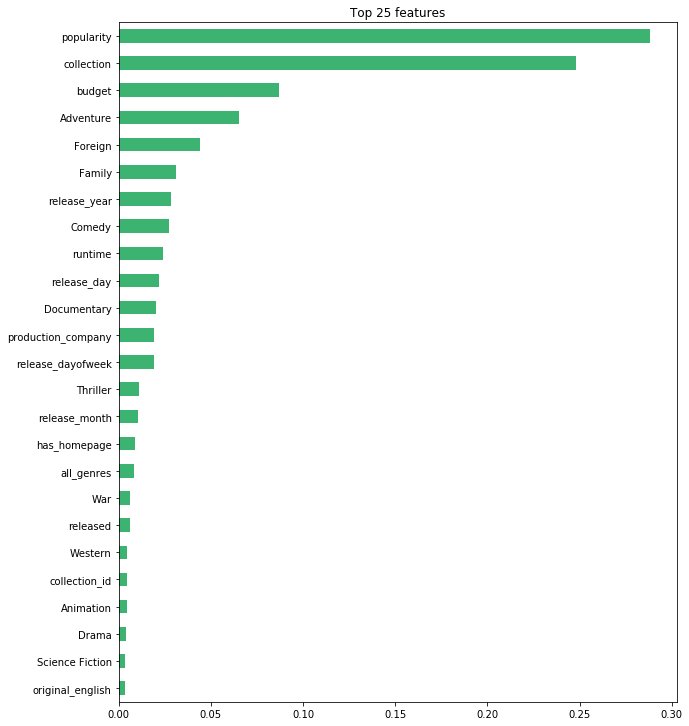

In [66]:
# Get feature importances
importances = pd.Series(model.feature_importances_, X_train.columns)

# Plot feature importances
n = 25
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='mediumseagreen');

In [67]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
2.7858 ± 0.7588,budget
1.3276 ± 0.1710,popularity
0.2151 ± 0.1250,release_year
0.1537 ± 0.0648,runtime
0.1463 ± 0.0528,collection
0.0982 ± 0.0563,production_company
0.0730 ± 0.1186,all_genres
0.0578 ± 0.0250,release_day
0.0474 ± 0.0523,Comedy
0.0346 ± 0.0086,Family


### Find manageable subset of features for Plotly Dash app

In [106]:
best_features = ['budget', 'collection', 'release_year', 'runtime', 
                 'Foreign', 'Documentary', 'Comedy', 'original_english', 
                 'release_month', 'Drama', 'Romance', 'has_homepage', 
                'Adventure', 'Animation']

In [107]:
X_train_selected = X_train_encoded[best_features]
X_val_selected = X_val_encoded[best_features]
X_test_selected = X_test_encoded[best_features]

In [108]:
X_train_selected.to_csv('X_train_selected.csv')
y_train_log.to_csv('y_train_log.csv')

In [109]:
eval_set = [(X_train_selected, y_train_log),
            (X_val_selected, y_val_log)]

model = XGBRegressor(n_estimators=1000, n_jobs=-1, eta=0.01, max_depth=2)
model.fit(X_train_selected, y_train_log, eval_set=eval_set, eval_metric='rmse',
         early_stopping_rounds=50)

[0]	validation_0-rmse:14.2213	validation_1-rmse:14.3022
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:12.847	validation_1-rmse:12.9203
[2]	validation_0-rmse:11.6146	validation_1-rmse:11.6801
[3]	validation_0-rmse:10.5084	validation_1-rmse:10.5651
[4]	validation_0-rmse:9.51799	validation_1-rmse:9.56287
[5]	validation_0-rmse:8.63258	validation_1-rmse:8.67065
[6]	validation_0-rmse:7.84228	validation_1-rmse:7.87053
[7]	validation_0-rmse:7.13674	validation_1-rmse:7.15092
[8]	validation_0-rmse:6.50895	validation_1-rmse:6.51172
[9]	validation_0-rmse:5.95154	validation_1-rmse:5.94251
[10]	validation_0-rmse:5.4581	validation_1-rmse:5.43684
[11]	validation_0-rmse:5.02104	validation_1-rmse:4.98639
[12]	validation_0-rmse:4.6367	validation_1-rmse:4.58649
[13]	validation_0-rmse:4.29993	validation_1-rmse:4.23574
[14]	validation_0-rmse:4.00507	validation_1-rmse:3.92485

[141]	validation_0-rmse:2.11554	validation_1-rmse:1.98365
[142]	validation_0-rmse:2.11539	validation_1-rmse:1.98377
[143]	validation_0-rmse:2.10989	validation_1-rmse:1.9842
[144]	validation_0-rmse:2.10926	validation_1-rmse:1.98392
[145]	validation_0-rmse:2.10883	validation_1-rmse:1.98352
[146]	validation_0-rmse:2.10846	validation_1-rmse:1.98383
[147]	validation_0-rmse:2.10781	validation_1-rmse:1.98271
[148]	validation_0-rmse:2.10769	validation_1-rmse:1.98282
[149]	validation_0-rmse:2.1072	validation_1-rmse:1.98273
[150]	validation_0-rmse:2.10661	validation_1-rmse:1.9826
[151]	validation_0-rmse:2.10195	validation_1-rmse:1.97316
[152]	validation_0-rmse:2.10126	validation_1-rmse:1.97444
[153]	validation_0-rmse:2.10074	validation_1-rmse:1.97793
[154]	validation_0-rmse:2.10018	validation_1-rmse:1.97949
[155]	validation_0-rmse:2.10006	validation_1-rmse:1.97918
[156]	validation_0-rmse:2.09943	validation_1-rmse:1.97944
[157]	validation_0-rmse:2.09538	validation_1-rmse:1.9799
[158]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.01, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [110]:
pipeline = make_pipeline(
    XGBRegressor(n_estimators=200, n_jobs=-1, eta=0.01, max_depth=2)
)
pipeline.fit(X_train_selected, y_train_log)

Pipeline(memory=None,
     steps=[('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.01, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))])

In [111]:
from joblib import dump, load

In [112]:
dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [113]:
# Kaggle RMSLE: 
generate_xgb_submission(model, X_test_selected, 434, 'tmdb_sub_24.csv')

In [114]:
permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_selected, y_val_log)
feature_names = X_val_selected.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
3.8427 ± 0.0859,budget
0.5500 ± 0.1257,release_year
0.4558 ± 0.2680,runtime
0.1528 ± 0.0740,collection
0.0892 ± 0.1495,original_english
0.0703 ± 0.0289,Documentary
0.0485 ± 0.0967,Drama
0.0420 ± 0.0099,has_homepage
0.0368 ± 0.0583,Comedy
0.0231 ± 0.0400,release_month


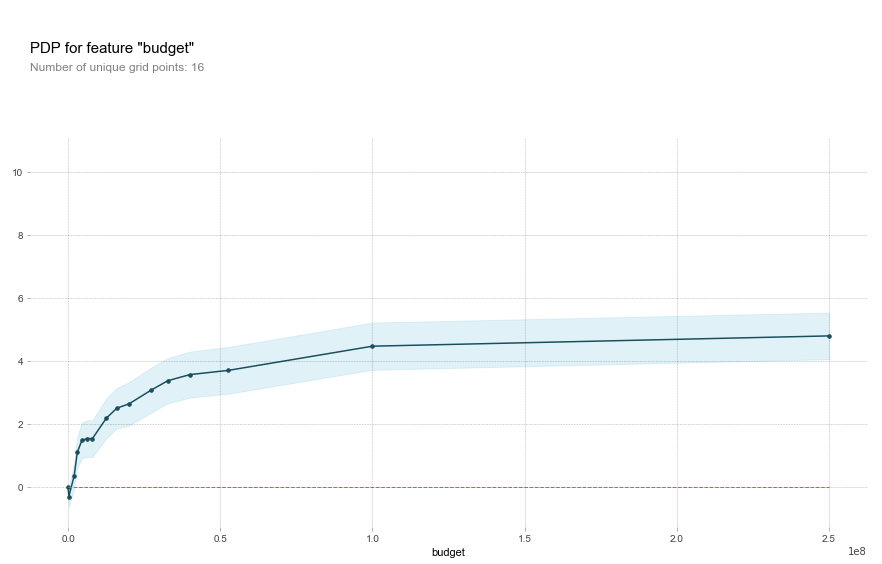

In [115]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'budget'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature);

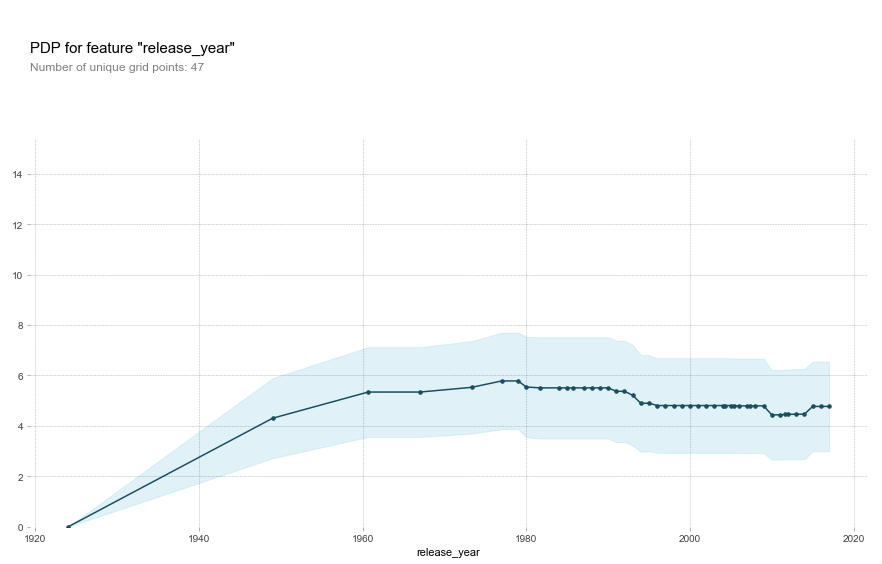

In [116]:
feature = 'release_year'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

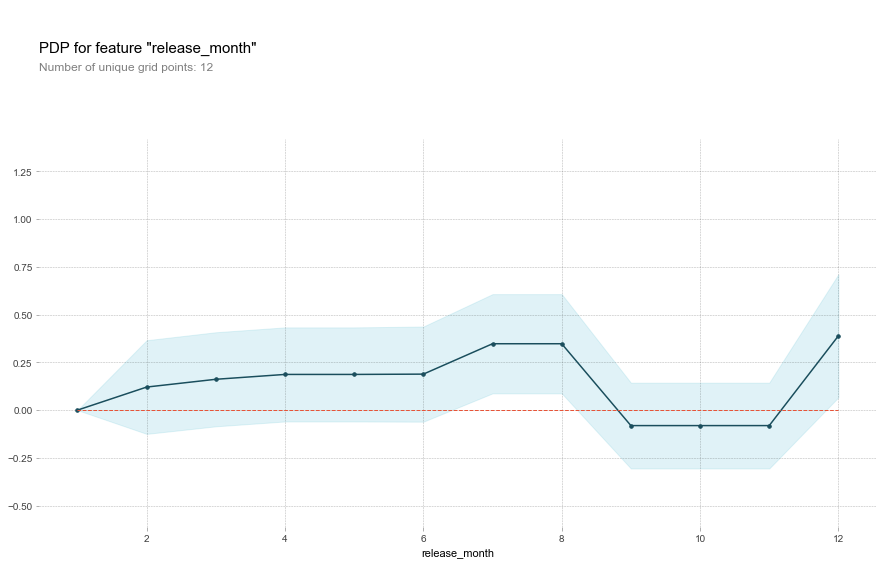

In [117]:
feature = 'release_month'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=15
)

pdp_plot(isolated, feature_name=feature);

In [118]:
# Is September a 'dump month?'
# Conventional wisdom is that back to school shopping competes for the money
# And football competes for the attention

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train_wrangled[(train_wrangled['release_month']==8) & (train_wrangled['revenue']>50000000)][['original_title', 'budget', 'revenue', 'release_year']]

,original_title,budget,revenue,release_year
1,The Princess Diaries 2: Royal Engagement,40000000,95149435,2004
6,The Possession,14000000,85446075,2012
16,Red Eye,26000000,57891803,2005
19,Transporter 2,32000000,85167639,2005
34,Rush Hour 3,140000000,258022233,2007
120,Rush Hour 2,90000000,347325802,2001
147,Snowpiercer,39200000,86758912,2013
216,STAND BY ME ドラえもん,35000000,83061158,2014
271,Talladega Nights: The Ballad of Ricky Bobby,72500000,162966177,2006
279,Collateral,65000000,217764291,2004


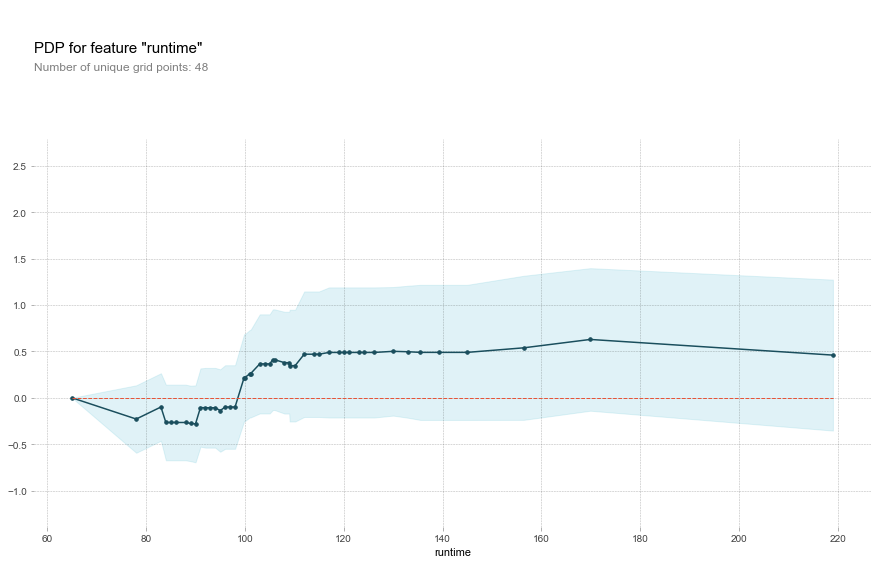

In [119]:
# Steady increase until a little over 100 minutes
# 75 minutes is the SAG cutoff to be counted as a feature film, 
# so that explains the sparsity of runtimes lower than that.

feature = 'runtime'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=50
)

pdp_plot(isolated, feature_name=feature);

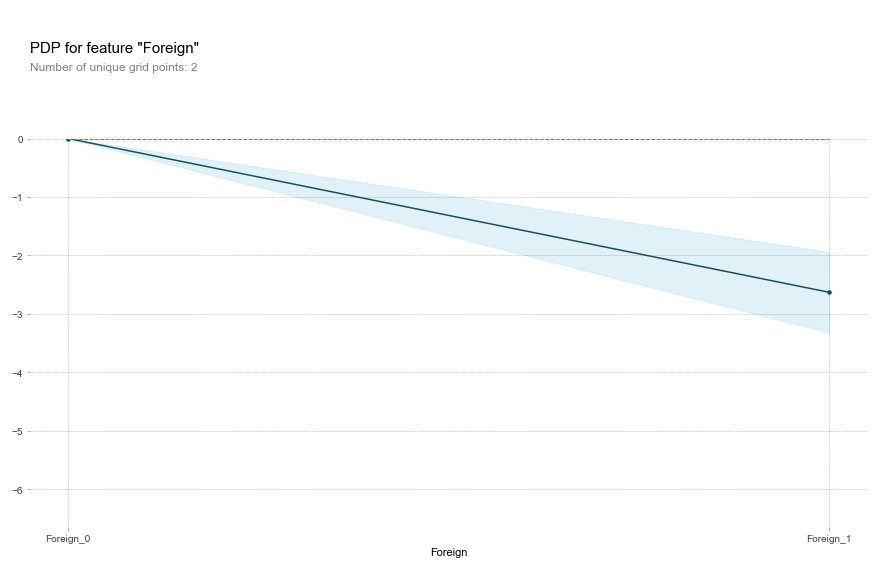

In [120]:
# Foreign films don't do as well at the box office
feature = 'Foreign'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=2
)

pdp_plot(isolated, feature_name=feature);

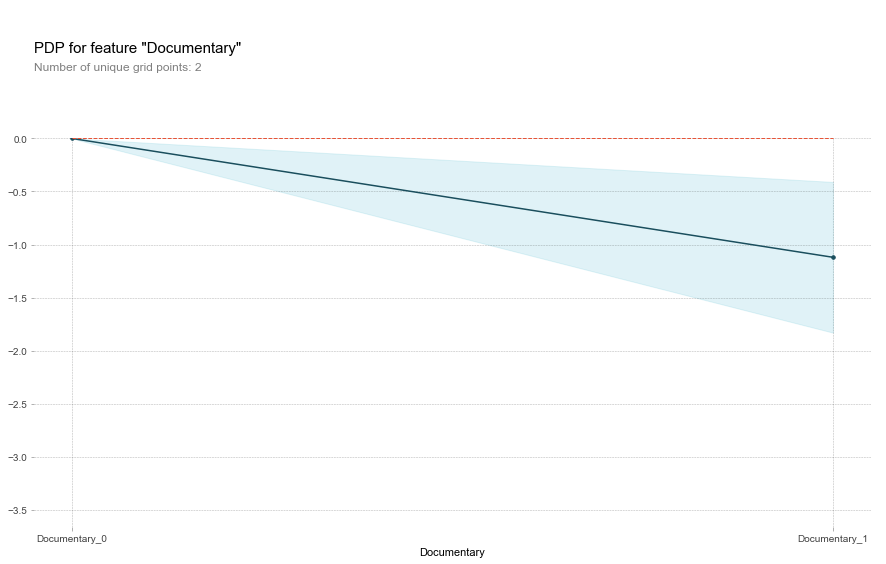

In [121]:
# Neither do documentaries. But not as bad as Foreign.
feature = 'Documentary'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

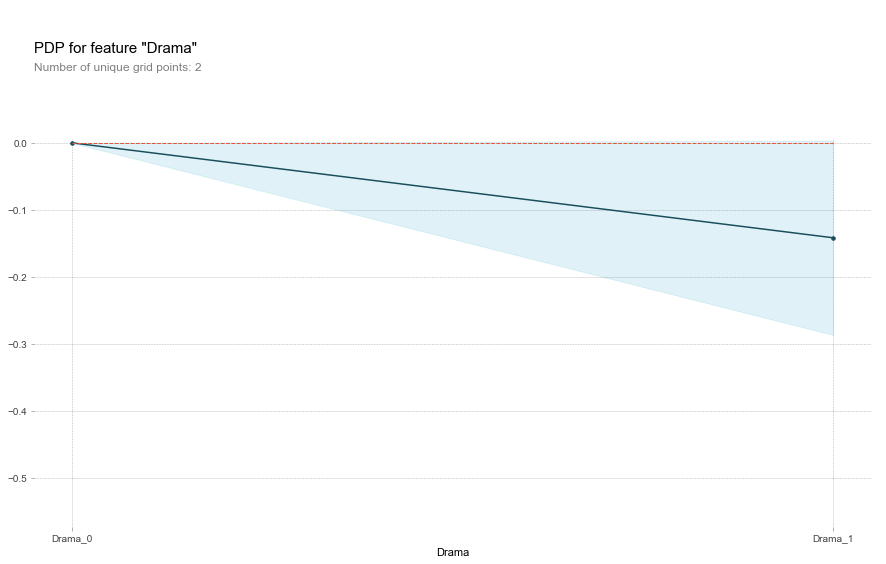

In [122]:
# Drama sees a moderate decline in revenue
feature = 'Drama'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

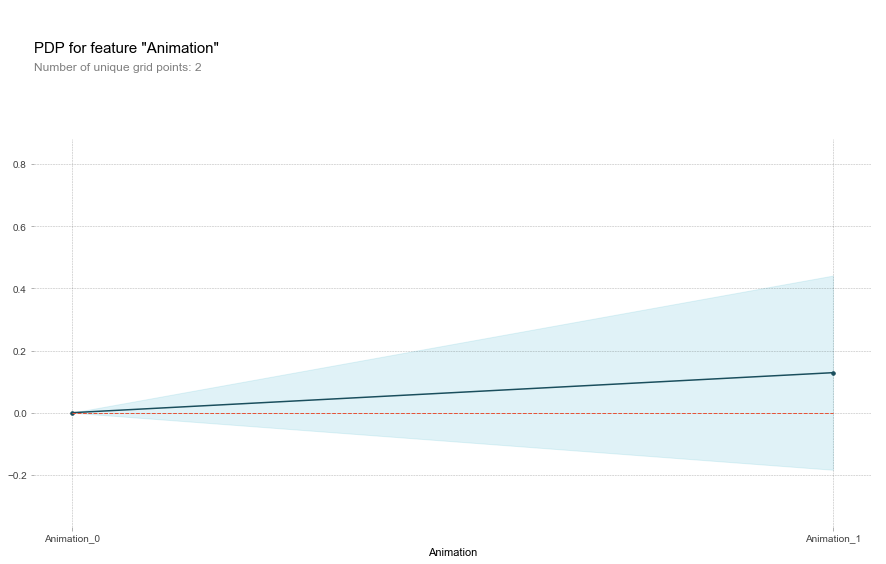

In [123]:
# Animation gives a slight box office bump
feature = 'Animation'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

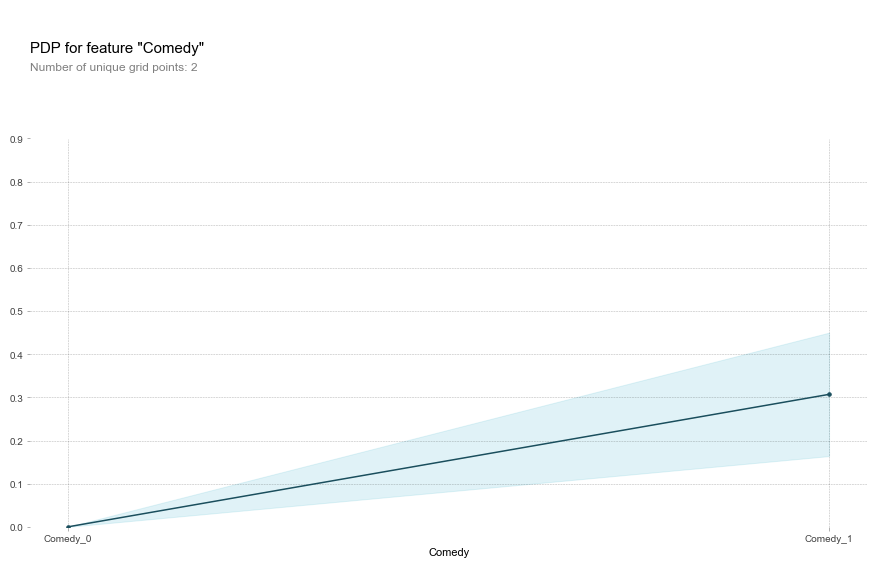

In [124]:
# Slight bump for comedy as well
feature = 'Comedy'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

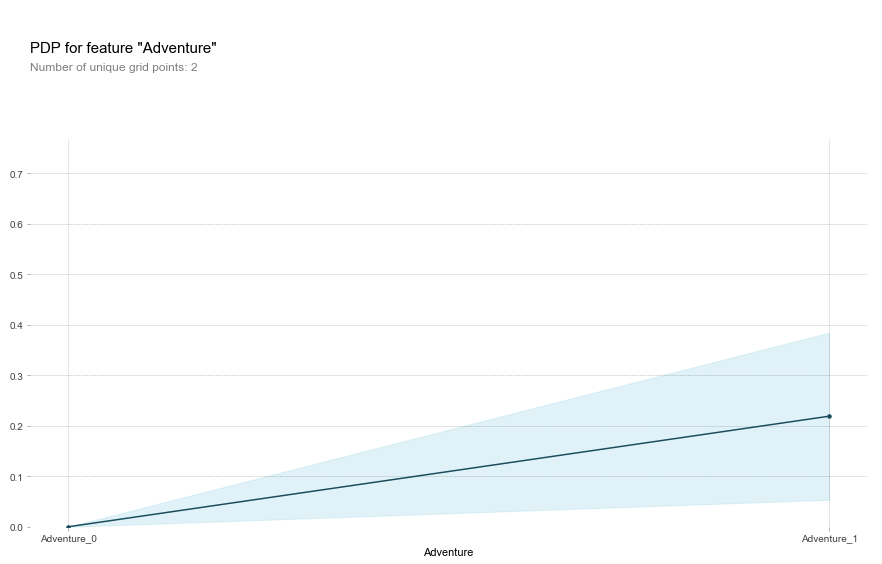

In [125]:
# Moderate bump. I thought it would be greater, since so many superhero
# blockbusters are Action|Adventure|Sci-fi. But the model probably picked
# up on other features that covary with genre.
feature = 'Adventure'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

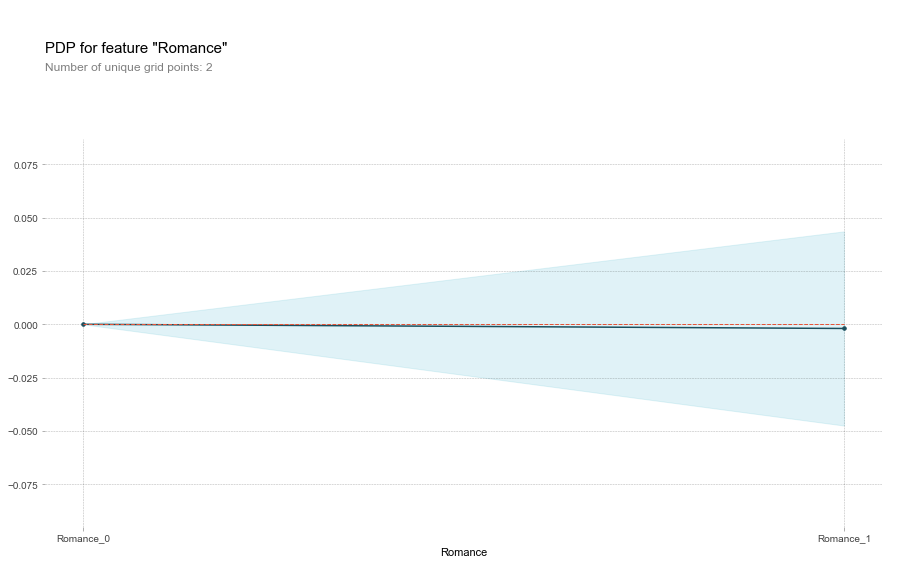

In [126]:
# Very slight decline for Romance
feature = 'Romance'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

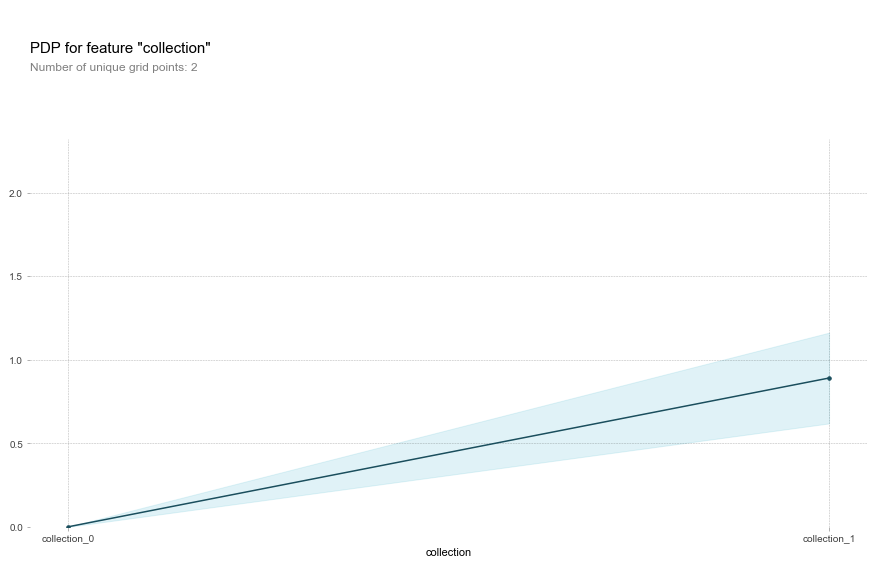

In [127]:
# Being part of a collection gives a sizeable bump. This is likely because 
# established IP gets big budgets and plenty of advertising, and is seen
# as a safer bet at the box office.

feature = 'collection'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

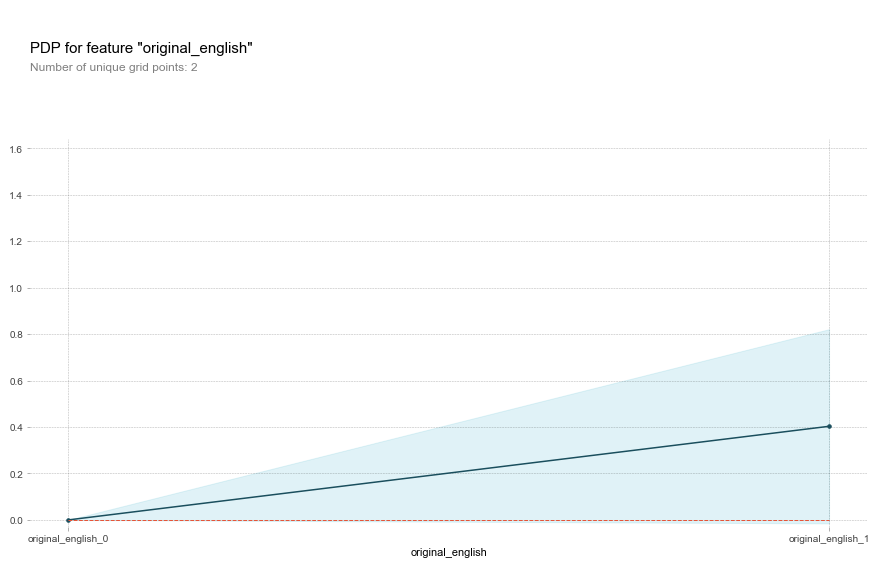

In [128]:
# Films originally in English see a bump as well
feature = 'original_english'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

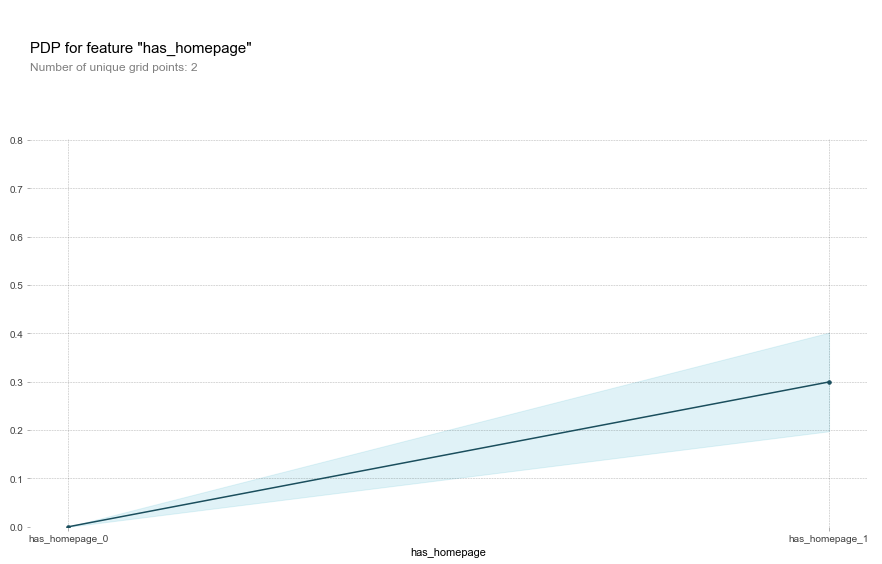

In [129]:
# A homepage seems to bump box office revenue as well.
feature = 'has_homepage'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);